In [1]:
# Basic Libraries
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from logging import getLogger, StreamHandler, INFO
%matplotlib inline

# sklearn libraries
from sklearn.model_selection import train_test_split,RandomizedSearchCV
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score

# Tensorflow libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
print(tf.__version__)

2.7.0


In [3]:
# check for the gpu device
device_name = tf.test.gpu_device_name()
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
!pip install rdkit-pypi

     |████████████████████████████████| 20.6 MB 10.9 MB/s 


In [4]:
from rdkit import rdBase
from rdkit import Chem
print(rdBase.rdkitVersion)

2021.09.4


In [ ]:
!pip install git+https://github.com/samoturk/mol2vec

  Cloning https://github.com/samoturk/mol2vec to /tmp/pip-req-build-1amgyiix
  Running command git clone -q https://github.com/samoturk/mol2vec /tmp/pip-req-build-1amgyiix
  Created wheel for mol2vec: filename=mol2vec-0.1-py3-none-any.whl size=14038 sha256=c8ad8dceb7520e43985c5bd9945f5f42c9a34ce896b1bef50c1bf66809024455
  Stored in directory: /tmp/pip-ephem-wheel-cache-_lofwg58/wheels/80/d5/e1/90dc211e4a17780f99eaec43328470a70284cd731ef2a77034
Successfully built mol2vec


In [5]:
from gensim.models import word2vec
from mol2vec import features
from mol2vec import helpers
from mol2vec.features import mol2alt_sentence, mol2sentence, MolSentence, DfVec, sentences2vec

## Load Data and Preprocess

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
print(os.getcwd())

Mounted at /content/gdrive
/content


In [6]:
# import data
drug_dataset = pd.read_csv("/content/gdrive/MyDrive/Datasets/Drug Repurposing/supercompf.csv")
drug_dataset.shape

(9002, 29)

In [7]:
drug_dataset.head()

,Unnamed: 0,ind1,ind2,vina_score,Unnamed: 3,smiles,mol,carbonyl,carboxylic acid,primary amine,alcohol,ester,amide,acid halide,fluorine halide,chlorine halide,bromine halide,iodine halide,anhydride,ether,secondary amine,enamine,alene,vinyl,phenol,fluorine,chlorine,Bromine,Iodine
0,0,0,0,-10.6,ERGOTAMINE,CC1(C(=O)N2C(C(=O)N3CCCC3C2(O1)O)CC4=CC=CC=C4)...,<rdkit.Chem.rdchem.Mol object at 0x7f562a245df0>,3,0,0,1,0,3,3,0,0,0,0,0,1,0,0,0,2,0,0,0,0,0
1,1,1,1,-10.0,METERGOTAMINE,CC1(C(=O)N2C(C(=O)N3CCCC3C2(O1)O)CC4=CC=CC=C4)...,<rdkit.Chem.rdchem.Mol object at 0x7f562a245e40>,3,0,0,1,0,3,3,0,0,0,0,0,1,0,0,0,2,0,0,0,0,0
2,2,2,2,-9.9,ABBV-744,CCNC(=O)C1=CC2=C(N1)C(=O)N(C=C2C3=C(C=CC(=C3)C...,<rdkit.Chem.rdchem.Mol object at 0x7f562a245e90>,1,0,0,1,0,1,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0
3,3,3,3,-9.9,DERQUANTEL,CC1(C=COC2=C(O1)C=CC3=C2NCC34CC56CN7CCC(C7(CC5...,<rdkit.Chem.rdchem.Mol object at 0x7f562a245ee0>,1,0,0,1,0,1,1,0,0,0,0,0,2,1,1,0,2,0,0,0,0,0
4,4,4,4,-9.9,MERGOCRIPTINE,CC1=C2CC3C(=CC(CN3C)C(=O)NC4(C(=O)N5C(C(=O)N6C...,<rdkit.Chem.rdchem.Mol object at 0x7f562a245f30>,3,0,0,1,0,3,3,0,0,0,0,0,1,0,0,0,2,0,0,0,0,0


In [8]:
X_full_df = drug_dataset[['smiles','vina_score']]
print(X_full_df.shape)
X_full_df.head()

(9002, 2)


,smiles,vina_score
0,CC1(C(=O)N2C(C(=O)N3CCCC3C2(O1)O)CC4=CC=CC=C4)...,-10.6
1,CC1(C(=O)N2C(C(=O)N3CCCC3C2(O1)O)CC4=CC=CC=C4)...,-10.0
2,CCNC(=O)C1=CC2=C(N1)C(=O)N(C=C2C3=C(C=CC(=C3)C...,-9.9
3,CC1(C=COC2=C(O1)C=CC3=C2NCC34CC56CN7CCC(C7(CC5...,-9.9
4,CC1=C2CC3C(=CC(CN3C)C(=O)NC4(C(=O)N5C(C(=O)N6C...,-9.9


In [9]:
X_full_df['molecules'] = X_full_df['smiles'].apply(lambda x: Chem.MolFromSmiles(x))
X_full_df.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,smiles,vina_score,molecules
0,CC1(C(=O)N2C(C(=O)N3CCCC3C2(O1)O)CC4=CC=CC=C4)...,-10.6,"<img data-content=""rdkit/molecule"" src=""data:i..."
1,CC1(C(=O)N2C(C(=O)N3CCCC3C2(O1)O)CC4=CC=CC=C4)...,-10.0,"<img data-content=""rdkit/molecule"" src=""data:i..."
2,CCNC(=O)C1=CC2=C(N1)C(=O)N(C=C2C3=C(C=CC(=C3)C...,-9.9,"<img data-content=""rdkit/molecule"" src=""data:i..."
3,CC1(C=COC2=C(O1)C=CC3=C2NCC34CC56CN7CCC(C7(CC5...,-9.9,"<img data-content=""rdkit/molecule"" src=""data:i..."
4,CC1=C2CC3C(=CC(CN3C)C(=O)NC4(C(=O)N5C(C(=O)N6C...,-9.9,"<img data-content=""rdkit/molecule"" src=""data:i..."


In [10]:
# drop missing value, if any
X_full_df = X_full_df.dropna(axis=0)
X_full_df.shape

(9002, 3)

In [11]:
X_full_df.vina_score.describe()

count    9002.000000
mean       -6.552066
std         1.107641
min       -10.600000
25%        -7.300000
50%        -6.700000
75%        -5.900000
max        -1.300000
Name: vina_score, dtype: float64

0.7008733166633144

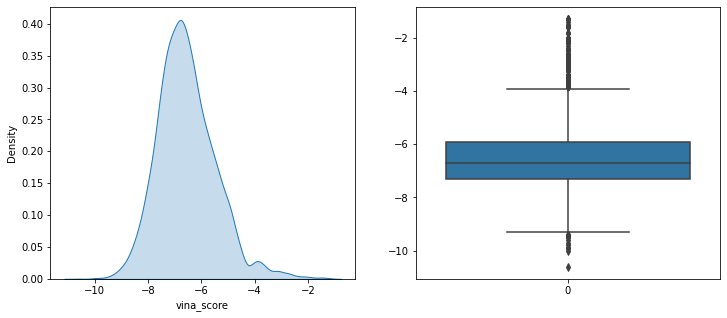

In [12]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.kdeplot(data=X_full_df['vina_score'], shade=True)
plt.subplot(1,2,2)
sns.boxplot(data=X_full_df['vina_score'])
X_full_df['vina_score'].skew()

In [13]:
# target variables
y_full_df = X_full_df['vina_score']
print(y_full_df.shape)
y_full_df.head()

(9002,)


0   -10.6
1   -10.0
2    -9.9
3    -9.9
4    -9.9
Name: vina_score, dtype: float64

In [14]:
X_full_df.drop(['vina_score'], axis=1, inplace=True)
X_full_df.shape

(9002, 2)

In [15]:
X_full_df['sentence'] = X_full_df.apply(lambda x: MolSentence(mol2alt_sentence(x['molecules'], 1)), axis=1)
X_full_df.head()

,smiles,molecules,sentence
0,CC1(C(=O)N2C(C(=O)N3CCCC3C2(O1)O)CC4=CC=CC=C4)...,"<img data-content=""rdkit/molecule"" src=""data:i...","(2246728737, 1861965050, 2976816164, 417788840..."
1,CC1(C(=O)N2C(C(=O)N3CCCC3C2(O1)O)CC4=CC=CC=C4)...,"<img data-content=""rdkit/molecule"" src=""data:i...","(2246728737, 1861965050, 2976816164, 417788840..."
2,CCNC(=O)C1=CC2=C(N1)C(=O)N(C=C2C3=C(C=CC(=C3)C...,"<img data-content=""rdkit/molecule"" src=""data:i...","(2246728737, 3542456614, 2245384272, 773607102..."
3,CC1(C=COC2=C(O1)C=CC3=C2NCC34CC56CN7CCC(C7(CC5...,"<img data-content=""rdkit/molecule"" src=""data:i...","(2246728737, 1861965050, 2976816164, 247601566..."
4,CC1=C2CC3C(=CC(CN3C)C(=O)NC4(C(=O)N5C(C(=O)N6C...,"<img data-content=""rdkit/molecule"" src=""data:i...","(2246728737, 422715066, 3217380708, 1308598964..."


In [16]:
model = word2vec.Word2Vec.load('/content/gdrive/MyDrive/Models/model_300dim.pkl')
X_full_df['mol2vec'] = [DfVec(x) for x in sentences2vec(X_full_df['sentence'], model, unseen='UNK')]
X_full_df.head()

,smiles,molecules,sentence,mol2vec
0,CC1(C(=O)N2C(C(=O)N3CCCC3C2(O1)O)CC4=CC=CC=C4)...,"<img data-content=""rdkit/molecule"" src=""data:i...","(2246728737, 1861965050, 2976816164, 417788840...","(300,) dimensional vector"
1,CC1(C(=O)N2C(C(=O)N3CCCC3C2(O1)O)CC4=CC=CC=C4)...,"<img data-content=""rdkit/molecule"" src=""data:i...","(2246728737, 1861965050, 2976816164, 417788840...","(300,) dimensional vector"
2,CCNC(=O)C1=CC2=C(N1)C(=O)N(C=C2C3=C(C=CC(=C3)C...,"<img data-content=""rdkit/molecule"" src=""data:i...","(2246728737, 3542456614, 2245384272, 773607102...","(300,) dimensional vector"
3,CC1(C=COC2=C(O1)C=CC3=C2NCC34CC56CN7CCC(C7(CC5...,"<img data-content=""rdkit/molecule"" src=""data:i...","(2246728737, 1861965050, 2976816164, 247601566...","(300,) dimensional vector"
4,CC1=C2CC3C(=CC(CN3C)C(=O)NC4(C(=O)N5C(C(=O)N6C...,"<img data-content=""rdkit/molecule"" src=""data:i...","(2246728737, 422715066, 3217380708, 1308598964...","(300,) dimensional vector"


In [17]:
# get target and feature as numpy array
X_full = np.array([x.vec for x in X_full_df['mol2vec']])
y_full = np.array(y_full_df)
print(X_full.shape)
print(y_full.shape)

(9002, 300)
(9002,)


In [18]:
# split data in train and test set
X_train,X_test,y_train,y_test = train_test_split(X_full, y_full, test_size=0.2, random_state=1)

In [19]:
# convert numpy arrays into tensor
X_train = tf.convert_to_tensor(X_train)
X_test = tf.convert_to_tensor(X_test)
y_train = tf.convert_to_tensor(y_train)
y_test = tf.convert_to_tensor(y_test)

In [20]:
# normalize the input tensors
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(X_train)
print(normalizer.mean.shape)
print(normalizer.variance.shape)

(1, 300)
(1, 300)


## Training the model

In [21]:
BUFFER_SIZE = 10000
BATCH_SIZE = 32
STEPS_PER_EPOCH = X_train.shape[0]//BATCH_SIZE
NUM_EPOCHS = 150

In [22]:
# get tf datasets
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(BUFFER_SIZE, seed=1).batch(BATCH_SIZE)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).shuffle(BUFFER_SIZE, seed=1).batch(BATCH_SIZE)

In [23]:
# Schedule to decrease the learning rate for better training
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(initial_learning_rate=0.001, decay_steps=STEPS_PER_EPOCH*20, 
                                                             decay_rate=1, staircase=False)

# Early stopping to stop unnecessary training
def get_callbacks():
  return tf.keras.callbacks.EarlyStopping(monitor='val_mean_squared_error', patience=25)

In [24]:
def conv_model(input_shape=(300,)):
    """
    DNN model for prediction of vina scores
    Argument:
    input_shape = shape of one feature vector
    """
    inputs = tf.keras.Input(shape=input_shape)
    x = normalizer(inputs)
    x = layers.Dense(4096, activation = 'relu')(x)
    x = layers.Reshape((64,64,1))(x)
    x = layers.Conv2D(16, (3, 3), strides = 1, padding = 'same')(x)
    x = layers.BatchNormalization(axis = 3)(x)
    x = layers.ReLU()(x)
    x = layers.MaxPool2D(pool_size = (2, 2), strides = 2)(x)
    x = layers.Flatten()(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(256, activation = 'relu',kernel_regularizer=tf.keras.regularizers.l2(0.0001))(x)
    outputs = layers.Dense(1)(x)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    return model

In [30]:
drug_model = conv_model()
drug_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
                  loss=tf.keras.losses.MeanSquaredError(),
                  metrics=['mean_squared_error', 'mean_absolute_error'])
drug_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 300)]             0         
                                                                 
 normalization (Normalizatio  (None, 300)              601       
 n)                                                              
                                                                 
 dense_3 (Dense)             (None, 4096)              1232896   
                                                                 
 reshape_1 (Reshape)         (None, 64, 64, 1)         0         
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 16)        160       
                                                                 
 batch_normalization_1 (Batc  (None, 64, 64, 16)       64        
 hNormalization)                                           

In [31]:
#history = drug_model.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS, validation_data=(X_test,y_test), callbacks=get_callbacks())
history = drug_model.fit(train_dataset, epochs=BATCH_SIZE, validation_data=test_dataset, callbacks=get_callbacks())

Epoch 1/150
226/226 [==============================] - 4s 16ms/step - loss: 91.3418 - mean_squared_error: 91.2809 - mean_absolute_error: 1.9951 - val_loss: 16.8405 - val_mean_squared_error: 16.7790 - val_mean_absolute_error: 4.0118
Epoch 2/150
226/226 [==============================] - 3s 15ms/step - loss: 0.5323 - mean_squared_error: 0.4711 - mean_absolute_error: 0.5167 - val_loss: 2.2070 - val_mean_squared_error: 2.1461 - val_mean_absolute_error: 1.3790
Epoch 3/150
226/226 [==============================] - 3s 12ms/step - loss: 0.4419 - mean_squared_error: 0.3813 - mean_absolute_error: 0.4572 - val_loss: 0.3784 - val_mean_squared_error: 0.3182 - val_mean_absolute_error: 0.3998
Epoch 4/150
226/226 [==============================] - 3s 14ms/step - loss: 0.4417 - mean_squared_error: 0.3818 - mean_absolute_error: 0.4556 - val_loss: 0.4498 - val_mean_squared_error: 0.3902 - val_mean_absolute_error: 0.4484
Epoch 5/150
226/226 [==============================] - 3s 14ms/step - loss: 0.4256 -

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


[Text(0, 0.5, 'MAE'), Text(0.5, 0, 'Epoch')]

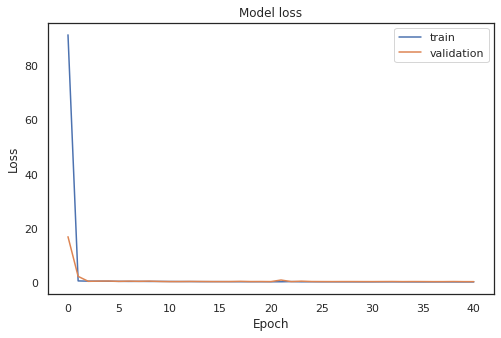

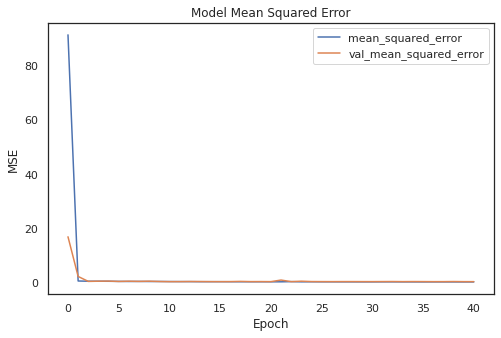

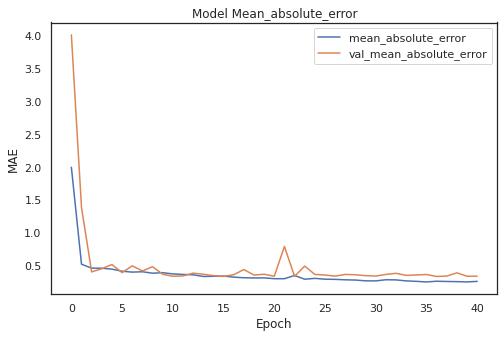

In [32]:
# plot training and validation losses to get an idea of overfitting and underfitting
df_loss_full = pd.DataFrame(history.history)
df_loss= df_loss_full[['loss','val_loss']]
df_loss.rename(columns={'loss':'train','val_loss':'validation'},inplace=True)
df_mse= df_loss_full[['mean_squared_error','val_mean_squared_error']]
df_mse.rename(columns={'accuracy':'train','val_accuracy':'validation'},inplace=True)
df_mae= df_loss_full[['mean_absolute_error','val_mean_absolute_error']]
df_mae.rename(columns={'accuracy':'train','val_accuracy':'validation'},inplace=True)
df_loss.plot(title='Model loss',figsize=(8,5)).set(xlabel='Epoch',ylabel='Loss')
df_mse.plot(title='Model Mean Squared Error',figsize=(8,5)).set(xlabel='Epoch',ylabel='MSE')
df_mae.plot(title='Model Mean_absolute_error',figsize=(8,5)).set(xlabel='Epoch',ylabel='MAE')

In [33]:
test_predictions = drug_model.predict(X_test)
mae,mse,r_square = mean_absolute_error(y_test,test_predictions),mean_squared_error(y_test,test_predictions),r2_score(y_test,test_predictions)
print('MAE score : {:.4f}'.format(mae))
print('MSE score : {:.4f}'.format(mse))
print('r2 score : {:.4f}'.format(r_square))

MAE score : 0.3347
MSE score : 0.2284
r2 score : 0.8170


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<function matplotlib.pyplot.show>

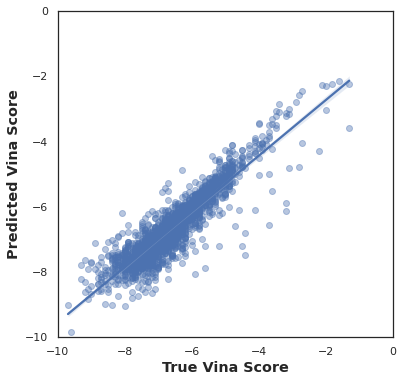

In [34]:
sns.set(color_codes=True)
sns.set_style("white")

ax = sns.regplot(y_test, test_predictions, scatter_kws={'alpha':0.4})
ax.set_xlabel('True Vina Score', fontsize='large', fontweight='bold')
ax.set_ylabel('Predicted Vina Score', fontsize='large', fontweight='bold')
ax.set_xlim(-10, 0)
ax.set_ylim(-10, 0)
ax.figure.set_size_inches(6, 6)
plt.show